# CNN Regression

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm  # Fortschrittsbalken-Bibliothek
from dataset_generator import create_embedding_matrix, split_data
from HumorDataset import TextRegDataset
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

# lokal imports
import ml_evaluation as ml_eval
import ml_helper
import ml_history
import dataset_generator as data_gen
# class imports
import HumorDataset as humor_ds
import EarlyStopping as EarlyStopping


In [2]:
torch.manual_seed(0)
np.random.seed(0)


best_model_filename = 'best_cnn_reg_model.pt'

device = ml_helper.get_device(verbose=True)

Using device: mps


In [3]:
# Hyperparameter und Konfigurationen
params = {
    "embedding_dim": 100,
    "filter_sizes": [2, 3, 4, 5],  # Zusätzliche Filtergröße
    "num_filters": 150,  # Erhöhte Anzahl von Filtern
    "batch_size": 32,
    "learning_rate": 0.001,
    "epochs": 25,
    "glove_path": 'data/glove.6B.100d.txt',  # Pfad zu GloVe
    "max_len": 280,
    "test_size": 0.1,
    "val_size": 0.1,
    "patience": 5,
    "data_path": 'data/hack.csv',  # Pfad zu den Daten
    "dropout": 0.6,  # Erhöhtes Dropout
    "weight_decay": 5e-4  # L2-Regularisierung
}

In [4]:
class CNNRegressor(nn.Module):
    def __init__(self, vocab_size, embedding_dim, filter_sizes, num_filters, embedding_matrix, dropout):
        super(CNNRegressor, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        
        # Convolutional Schichten mit Batch-Normalisierung
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(1, num_filters, (fs, embedding_dim)),
                nn.BatchNorm2d(num_filters),  # Batch-Normalisierung
                nn.ReLU(),
                nn.MaxPool2d((params["max_len"] - fs + 1, 1)),
                nn.Dropout(dropout)  # Dropout nach jeder Schicht
            )
            for fs in filter_sizes
        ])
        
        # Fully-Connected Layer
        self.fc1 = nn.Linear(len(filter_sizes) * num_filters, 128)  # Erweiterte Dense-Schicht
        self.fc2 = nn.Linear(128, 1)  # Ausgangsschicht (Regression)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)  # [Batch, 1, Seq, Embedding]
        conv_outputs = [conv(x).squeeze(3).squeeze(2) for conv in self.convs]  # Pooling reduziert Dim
        x = torch.cat(conv_outputs, 1)  # Kombiniere Features von allen Filtern
        x = torch.relu(self.fc1(x))  # Zusätzliche Dense-Schicht
        x = self.dropout(x)
        return self.fc2(x).squeeze(1)


In [5]:
# Funktion zum Laden und Vorverarbeiten der Daten
def load_preprocess_data(path_data='data/hack.csv'):
    # Daten laden
    df = pd.read_csv(path_data)

    # Fehlende Werte in der Zielspalte entfernen
    df = df.dropna(subset=['humor_rating'])

    # Zielvariable aus der Spalte 'humor_rating' extrahieren
    df['y'] = df['humor_rating'].astype(float)  # Sicherstellen, dass Zielvariable numerisch ist

    # Eingabetexte und Zielvariable zuweisen
    X = df['text']
    y = df['y']

    # Debug-Ausgabe zur Überprüfung
    print(f"Erste Zielwerte: {y.head(10)}")
    print(f"Datentyp der Zielvariable: {y.dtype}")
    print(f"Anzahl der Beispiele: {len(X)}")
    
    return X, y

In [6]:
# Visualisierung der Zielvariablen (Scores)
def visualize_data_distribution(y):
    print("\n--- Zielvariable: Statistik ---")
    print(f"Min: {np.min(y)}, Max: {np.max(y)}")
    print(f"Mittelwert: {np.mean(y):.4f}, Standardabweichung: {np.std(y):.4f}")
    
    # Histogramm plotten
    plt.figure(figsize=(10, 6))
    plt.hist(y, bins=20, color='skyblue', edgecolor='black')
    plt.title('Verteilung der Zielvariable (Scores)')
    plt.xlabel('Score')
    plt.ylabel('Häufigkeit')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


400002
vocab_size: 400002, d_model: 100
Erste Zielwerte: 0     2.42
1     2.50
2     1.95
3     2.11
4     2.78
7     1.79
11    2.20
12    1.50
13    2.16
17    1.78
Name: y, dtype: float64
Datentyp der Zielvariable: float64
Anzahl der Beispiele: 4932

--- Zielvariable: Statistik ---
Min: 0.1, Max: 4.0
Mittelwert: 2.2605, Standardabweichung: 0.5669


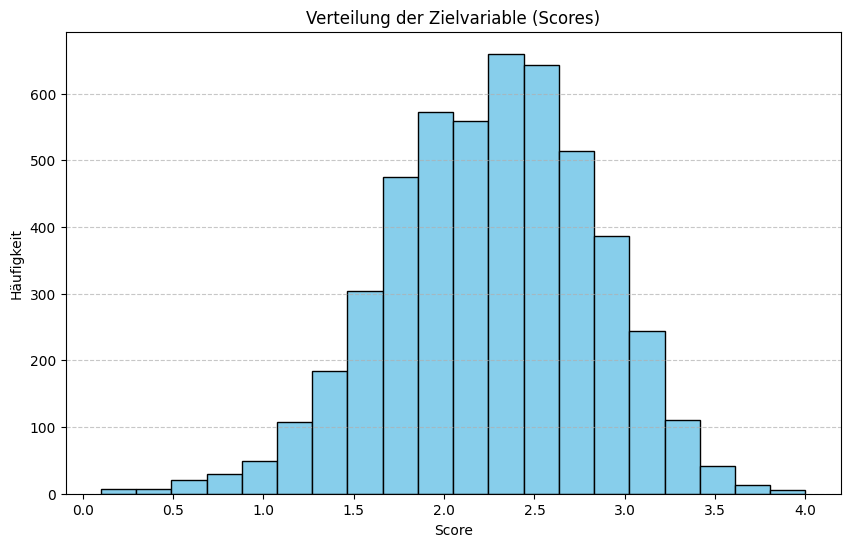

In [7]:
# Daten laden und vorbereiten
embedding_matrix, word_index, vocab_size, d_model = create_embedding_matrix(
    gloVe_path=params["glove_path"], emb_len=params["embedding_dim"]
)
X, y = load_preprocess_data(path_data=params["data_path"])

# Visualisierung der Daten
visualize_data_distribution(y)

In [8]:
# Aufteilen der Daten
data_split = split_data(X, y, test_size=params["test_size"], val_size=params["val_size"])

# Dataset und DataLoader
train_dataset = TextRegDataset(data_split['train']['X'], data_split['train']['y'], word_index, max_len=params["max_len"])
val_dataset = TextRegDataset(data_split['val']['X'], data_split['val']['y'], word_index, max_len=params["max_len"])
test_dataset = TextRegDataset(data_split['test']['X'], data_split['test']['y'], word_index, max_len=params["max_len"])

train_loader = DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=params["batch_size"], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=params["batch_size"], shuffle=False)


train 3945 3945
test 494 494
val 493 493


In [12]:
# Modell initialisieren
model = CNNRegressor(
    vocab_size=vocab_size,
    embedding_dim=params["embedding_dim"],
    filter_sizes=params["filter_sizes"],
    num_filters=params["num_filters"],
    embedding_matrix=embedding_matrix,
    dropout=params["dropout"]
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=params["learning_rate"], weight_decay=params["weight_decay"])
early_stopping = EarlyStopping.EarlyStopping(patience=params["patience"], verbose=True)


In [13]:

# Speicher für Trainingsmetriken
history = {
    "train_loss": [],
    "val_loss": [],
    "train_rmse": [],
    "val_rmse": [],
}

# Training und Validierung
for epoch in range(params["epochs"]):
    model.train()
    train_loss = 0.0
    train_preds, train_labels = [], []

    # Fortschrittsbalken für Training innerhalb einer Epoche
    with tqdm(train_loader, desc=f"Epoch {epoch + 1}/{params['epochs']}") as pbar:
        for X_batch, y_batch in pbar:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device).float()
            optimizer.zero_grad()
            predictions = model(X_batch).float()
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
            # Speichere echte und vorhergesagte Werte für Metriken
            train_preds.extend(predictions.cpu().detach().numpy())
            train_labels.extend(y_batch.cpu().detach().numpy())
            
            # Update der Fortschrittsanzeige
            pbar.set_postfix({"Train Loss": loss.item()})
    
    train_rmse = np.sqrt(mean_squared_error(train_labels, train_preds))  # RMSE
    history["train_loss"].append(train_loss / len(train_loader))
    history["train_rmse"].append(train_rmse)

    # Validation
    model.eval()
    val_loss = 0.0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device).float()
            predictions = model(X_batch).float()
            loss = criterion(predictions, y_batch)
            val_loss += loss.item()

            val_preds.extend(predictions.cpu().detach().numpy())
            val_labels.extend(y_batch.cpu().detach().numpy())

        val_rmse = np.sqrt(mean_squared_error(val_labels, val_preds))  # RMSE
    history["val_loss"].append(val_loss / len(val_loader))
    history["val_rmse"].append(val_rmse)

    print(f"\nEpoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    print(f"Train RMSE: {train_rmse:.4f}, Val RMSE: {val_rmse:.4f}")

    early_stopping(val_rmse, model)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break


Epoch 1/25: 100%|██████████| 124/124 [00:18<00:00,  6.78it/s, Train Loss=0.907]



Epoch 1, Train Loss: 272.8565, Val Loss: 8.8425
Train RMSE: 1.4859, Val RMSE: 0.7446
Validation loss decreased (-0.744646 --> 0.744646).  Saving model ...


Epoch 2/25: 100%|██████████| 124/124 [00:19<00:00,  6.44it/s, Train Loss=0.696]



Epoch 2, Train Loss: 98.9154, Val Loss: 9.4178
Train RMSE: 0.8935, Val RMSE: 0.7682


Epoch 3/25: 100%|██████████| 124/124 [00:19<00:00,  6.30it/s, Train Loss=1.79] 



Epoch 3, Train Loss: 93.6001, Val Loss: 7.3193
Train RMSE: 0.8653, Val RMSE: 0.6769
Validation loss decreased (-0.676914 --> 0.676914).  Saving model ...


Epoch 4/25: 100%|██████████| 124/124 [00:18<00:00,  6.58it/s, Train Loss=1.12] 



Epoch 4, Train Loss: 83.3528, Val Loss: 6.1189
Train RMSE: 0.8183, Val RMSE: 0.6187
Validation loss decreased (-0.618719 --> 0.618719).  Saving model ...


Epoch 5/25: 100%|██████████| 124/124 [00:19<00:00,  6.20it/s, Train Loss=0.866]



Epoch 5, Train Loss: 82.4167, Val Loss: 6.3834
Train RMSE: 0.8145, Val RMSE: 0.6317


Epoch 6/25: 100%|██████████| 124/124 [00:20<00:00,  6.13it/s, Train Loss=0.528]



Epoch 6, Train Loss: 76.5571, Val Loss: 6.5987
Train RMSE: 0.7861, Val RMSE: 0.6421


Epoch 7/25: 100%|██████████| 124/124 [00:20<00:00,  6.13it/s, Train Loss=0.135]



Epoch 7, Train Loss: 73.0328, Val Loss: 6.4774
Train RMSE: 0.7692, Val RMSE: 0.6361


Epoch 8/25: 100%|██████████| 124/124 [00:20<00:00,  6.07it/s, Train Loss=0.5]  



Epoch 8, Train Loss: 73.0788, Val Loss: 5.5935
Train RMSE: 0.7680, Val RMSE: 0.5913
Validation loss decreased (-0.591316 --> 0.591316).  Saving model ...


Epoch 9/25: 100%|██████████| 124/124 [00:20<00:00,  6.00it/s, Train Loss=0.747]



Epoch 9, Train Loss: 72.9909, Val Loss: 5.7356
Train RMSE: 0.7666, Val RMSE: 0.5987


Epoch 10/25: 100%|██████████| 124/124 [00:20<00:00,  6.07it/s, Train Loss=0.33] 



Epoch 10, Train Loss: 68.4401, Val Loss: 5.6286
Train RMSE: 0.7438, Val RMSE: 0.5931


Epoch 11/25: 100%|██████████| 124/124 [00:21<00:00,  5.90it/s, Train Loss=0.135]



Epoch 11, Train Loss: 72.3024, Val Loss: 6.8619
Train RMSE: 0.7653, Val RMSE: 0.6543


Epoch 12/25: 100%|██████████| 124/124 [00:20<00:00,  5.98it/s, Train Loss=0.353]



Epoch 12, Train Loss: 65.9048, Val Loss: 6.5378
Train RMSE: 0.7297, Val RMSE: 0.6390


Epoch 13/25: 100%|██████████| 124/124 [00:22<00:00,  5.55it/s, Train Loss=0.4]  



Epoch 13, Train Loss: 65.4947, Val Loss: 5.1140
Train RMSE: 0.7273, Val RMSE: 0.5665
Validation loss decreased (-0.566452 --> 0.566452).  Saving model ...


Epoch 14/25: 100%|██████████| 124/124 [00:23<00:00,  5.21it/s, Train Loss=0.515]



Epoch 14, Train Loss: 62.4101, Val Loss: 6.0987
Train RMSE: 0.7094, Val RMSE: 0.6177


Epoch 15/25: 100%|██████████| 124/124 [00:23<00:00,  5.38it/s, Train Loss=0.645]



Epoch 15, Train Loss: 64.4443, Val Loss: 9.2568
Train RMSE: 0.7204, Val RMSE: 0.7601


Epoch 16/25: 100%|██████████| 124/124 [00:24<00:00,  5.15it/s, Train Loss=0.288]



Epoch 16, Train Loss: 58.4627, Val Loss: 5.3123
Train RMSE: 0.6874, Val RMSE: 0.5776


Epoch 17/25: 100%|██████████| 124/124 [00:22<00:00,  5.43it/s, Train Loss=0.524]



Epoch 17, Train Loss: 58.4355, Val Loss: 5.5252
Train RMSE: 0.6863, Val RMSE: 0.5889


Epoch 18/25: 100%|██████████| 124/124 [00:21<00:00,  5.74it/s, Train Loss=0.223]



Epoch 18, Train Loss: 55.3765, Val Loss: 5.9419
Train RMSE: 0.6692, Val RMSE: 0.6100
Early stopping triggered.


In [14]:
# Plot-Funktion für Training
def plot_learning_curves(history):
    epochs = range(1, len(history['train_loss']) + 1)

    # Loss-Plot
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # RMSE-Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_rmse'], label='Train RMSE')
    plt.plot(epochs, history['val_rmse'], label='Val RMSE')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.title('Training and Validation RMSE')
    plt.legend()

    plt.tight_layout()
    plt.show()


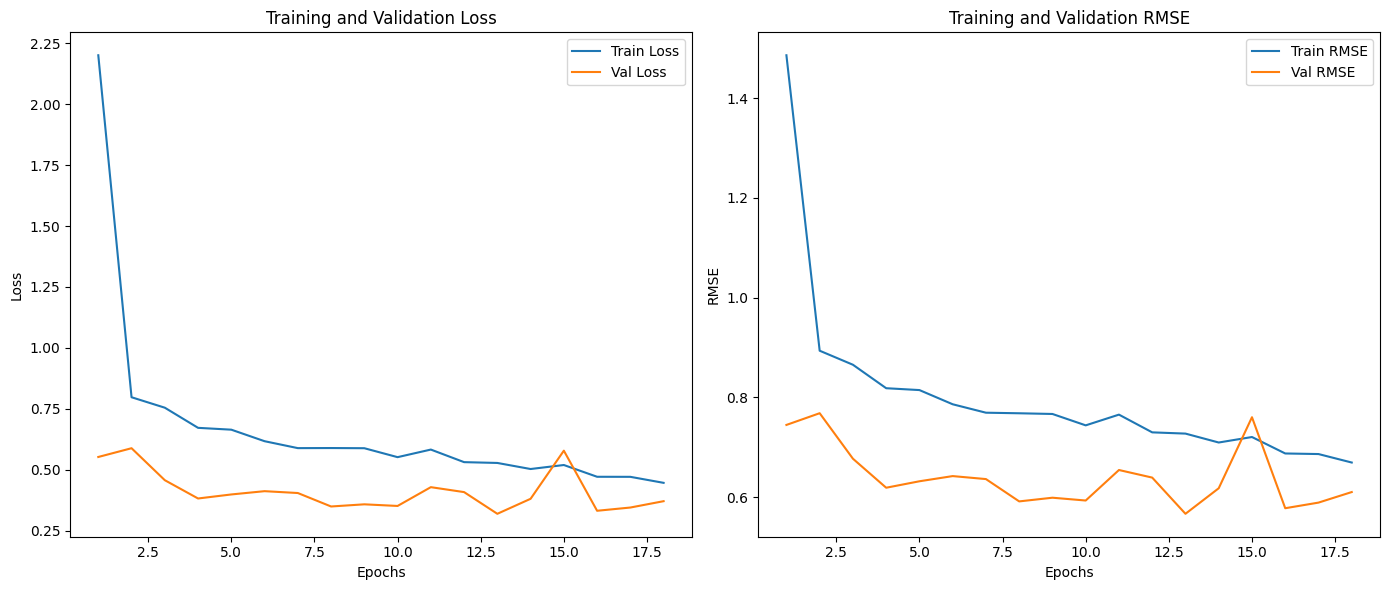

In [15]:
# Plot der Lernkurven
plot_learning_curves(history)
# Funktion zur Visualisierung der richtigen und falschen Vorhersagen
def visualize_predictions(true_values, predicted_values):
    plt.figure(figsize=(10, 6))
    
    # Unterschied zwischen vorhergesagten und wahren Werten
    correct_indices = np.isclose(true_values, predicted_values, atol=0.3)  # Als korrekt angenommen, wenn Differenz <= 0.3
    
    # Plot
    plt.scatter(true_values[correct_indices], predicted_values[correct_indices], color='green', label='Richtig vorhergesagt')
    plt.scatter(true_values[~correct_indices], predicted_values[~correct_indices], color='red', label='Falsch vorhergesagt')
    plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], color='blue', linestyle='--', label='Ideal-Linie')
    
    plt.xlabel('Wahre Werte')
    plt.ylabel('Vorhergesagte Werte')
    plt.title('Richtige vs Falsche Vorhersagen')
    plt.legend()
    plt.grid(True)
    plt.show()

In [16]:
# Test Evaluation
model.eval()
test_preds, test_labels = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device).float()
        predictions = model(X_batch).float()
        test_preds.extend(predictions.cpu().detach().numpy())
        test_labels.extend(y_batch.cpu().detach().numpy())


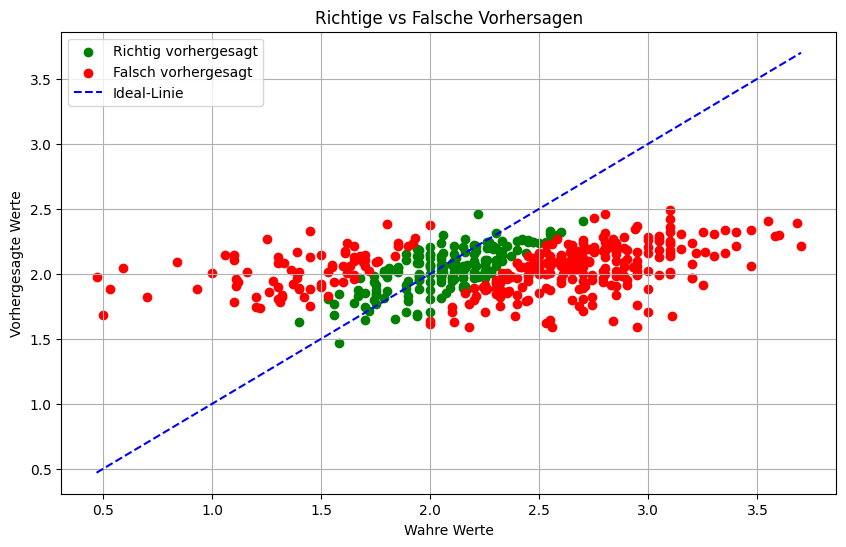

In [17]:
# Konvertierung zu NumPy-Arrays
true_values = np.array(test_labels)
predicted_values = np.array(test_preds)

# Visualisierung der Ergebnisse
visualize_predictions(true_values, predicted_values)


In [18]:
# RMSE, MAE und R²-Score für das Test-Set
test_rmse = np.sqrt(mean_squared_error(test_labels, test_preds))
test_mae = mean_absolute_error(test_labels, test_preds)
test_r2 = r2_score(test_labels, test_preds)
print(f"Test RMSE: {test_rmse:.4f}, Test MAE: {test_mae:.4f}, Test R²: {test_r2:.4f}")


Test RMSE: 0.5820, Test MAE: 0.4757, Test R²: -0.0582


In [19]:
# Funktion zur Visualisierung der richtigen und falschen Vorhersagen
def visualize_predictions(true_values, predicted_values):
    plt.figure(figsize=(10, 6))
    
    # Unterschied zwischen vorhergesagten und wahren Werten
    correct_indices = np.isclose(true_values, predicted_values, atol=0.3)  # Als korrekt angenommen, wenn Differenz <= 0.3
    
    # Plot
    plt.scatter(true_values[correct_indices], predicted_values[correct_indices], color='green', label='Richtig vorhergesagt')
    plt.scatter(true_values[~correct_indices], predicted_values[~correct_indices], color='red', label='Falsch vorhergesagt')
    plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], color='blue', linestyle='--', label='Ideal-Linie')
    
    plt.xlabel('Wahre Werte')
    plt.ylabel('Vorhergesagte Werte')
    plt.title('Richtige vs Falsche Vorhersagen')
    plt.legend()
    plt.grid(True)
    plt.show()

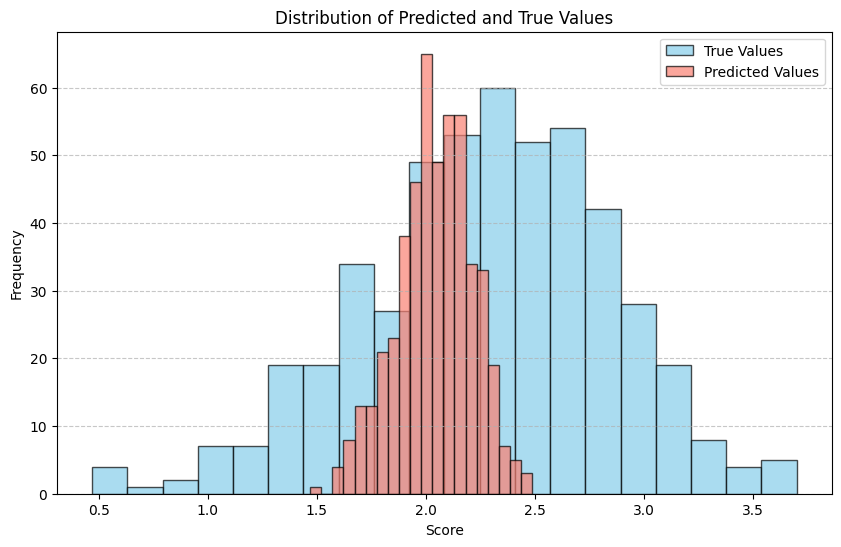

In [20]:
# plot distribution of predicted values and true values
plt.figure(figsize=(10, 6))
plt.hist(test_labels, bins=20, color='skyblue', edgecolor='black', alpha=0.7, label='True Values')
plt.hist(test_preds, bins=20, color='salmon', edgecolor='black', alpha=0.7, label='Predicted Values')
plt.title('Distribution of Predicted and True Values')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()